# Restricted Boltzmann Machine

[Restricted Boltzmann Machines](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) (RBMs) are a special type of neural networks (NNs) with 2 layers: a __visible layer__ and a __hidden layer__. A RBM is __restricted__ in the sense that there are no inter-node connections (nodes within a layer have no connections between one another). Thus, the visible-to-hidden architecture of a RBM forms what is called a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph). The application of RBMs span several problem areas, including but not limited to, natural language processing (NLP), recommendations, feature selection, and sequencing. 

One heavy use of RBMs is in the area of latent variable analysis; RBMs can be used to model observed variables with the visible layer and the latent or conceptual variables with the hidden layer. For example, in topic modeling, the visible nodes can represent words, and the hidden nodes can represent topics. Although a RBM is simply 2 layers, one may stack or chain together many RBMs in what is called a [deep belief network](https://en.wikipedia.org/wiki/Deep_belief_network). In a deep belief network, the output of the hidden layer of a RBM is the input to the next RBM. 

As with any NN, the connections between the nodes are associated with weights. However, learning these weights in a RBM is slightly different from learning the weights in other NNs. For example, when we learn the weights in a [multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron), we adjust the weights, __not__ directly with respect to the input variables, but the output variable (in supervised learning). On the other hand, when we learn the weights in a RBM, we adjust the weights directly with respect to the input variables. When using RBMs for latent variable analysis, typically, the number of nodes in the visible layer is larger than the number of nodes in the hidden layer; essentially, we are encoding the data in its original (visible) larger space to a smaller (hidden) space. As such, RBMs are often called [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) because they are compressing the data or reducing the dimensionality of the data. Now, in a deep belief network, in the context of latent variable analysis, subsequent layers may be interpreted as higher and higher abstractions of the data. Going back to topic modeling, words can be abstracted to topics such as tennis, football, soccer, sports utility vehicle, sedan, coupe, and those topics can be abstracted to higher order topics such as sports and cars. Generally speaking, in a deep networks, it is interpreted that each layer is learning a different feature of the data; for example, in image processing of faces, one layer may be learning the mouth, another the eyes, and another the ears. 

This notebook focuses only on RBMs. Since a RBM is a NN, the weights could be learned using gradient descent, but, the original approach to learning the weights is known as __contrastive divergence__, which is approximate gradient descent. What is contrastive divergence (CD)? One possibly good way to understand CD is to remember that we are encoding the data from high to low dimensional space, and if we are really good at encoding the data into lower dimensional space, then we can reconstruct or decode the data from lower dimensional space back to higher dimensional space faithfully. Going back to topic modeling, if we have encoded words (visible) to topics (hidden), we can see if the encoding was any good at all by generating words from the topics (decoding). If the distribution of words that we generate from the topics closely resembles the original distribution of words, then we have learned a pretty good RBM model. CD is a measure of the divergence of the original distribution of the data from the generated distribution of the data from the hidden nodes. This measure of distribution divergence is typically measured using the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). The magnitude of the CD is what we use to adjust the weights. Note the following equation on updating the weights.

$w^{*} = w + \alpha \nabla \log p(v)$

where

* $w^{*}$ is the new weight
* $w$ is the current weight
* $\alpha$ is the learning weight
* $\nabla \log p(v)$ is the gradient of the log probability of the data

This equation is essentially the same weight updating rule for all NNs. However, $\log p(v)$ cannot be computed directly, and instead, alternating [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) must be used. The use of alternating Gibbs sampling is not hard to understand; we alternate because we must sample from the hidden layer to generate the states of the visible layer, then we swap (alternate) to sampling from the visible layer to generate the states of the hidden layer. 

The code below is borrowed heavily from [here](http://blog.echen.me/2011/07/18/introduction-to-restricted-boltzmann-machines/). What is interesting about a RBM model is that after you learn it, you can do the following.

* query which hidden nodes are activated by which visible nodes
* query which visible nodes are activated by which hidden nodes
* let the model daydream or dream, by generating new data

Going back to topic modeling, we can 

* query which topics are associated with which words
* query which words are associated with which topics
* let the model generate new words

We have 2 examples to play with in this notebook. 

* Use a RBM to learn the categories of movie preferences.
* Use a RBM to learn the categories of names.

Additionally, we will learn the weights using batch, stochastic, and mini-batch descent methods and observe the error (loss) over training iterations.

## Example RBM architecture

In [1]:
%%html
<svg height="300" width="600">
    <!-- arcs from hidden unit 1 to visible units -->
    <line x1="160" y1="50" x2="40" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="120" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="200" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="280" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="360" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    <line x1="160" y1="50" x2="440" y2="200" style="stroke:rgb(0,0,0);stroke-width:1" />
    
    <!-- arcs from hidden unit 2 to visible units -->
    <line x1="320" y1="50" x2="40" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="120" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="200" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="280" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="360" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    <line x1="320" y1="50" x2="440" y2="200" style="stroke:rgb(180,180,180);stroke-width:1" />
    
    <line x1="540" y1="120" x2="160" y2="50" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="320" y2="50" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="40" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="120" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="200" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="280" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="360" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    <line x1="540" y1="120" x2="440" y2="200" style="stroke:rgba(0,100,0, 0.5);stroke-width:0.5" />
    
    <!-- hidden units -->
    <circle cx="160" cy="50" r="20" stroke="red" stroke-width="2" fill="white" />
    <circle cx="320" cy="50" r="20" stroke="red" stroke-width="2" fill="white" />
    
    <text x="154" y="55"><tspan>h<tspan dy="5">1</tspan></tspan></text>
    <text x="314" y="55"><tspan>h<tspan dy="5">2</tspan></tspan></text>
    
    <!-- visible units-->
    <circle cx="40" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="120" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="200" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="280" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="360" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    <circle cx="440" cy="200" r="20" stroke="blue" stroke-width="2" fill="white" />
    
    <text x="34" y="200"><tspan>v<tspan dy="5">1</tspan></tspan></text>
    <text x="114" y="200"><tspan>v<tspan dy="5">2</tspan></tspan></text>
    <text x="194" y="200"><tspan>v<tspan dy="5">3</tspan></tspan></text>
    <text x="274" y="200"><tspan>v<tspan dy="5">4</tspan></tspan></text>
    <text x="354" y="200"><tspan>v<tspan dy="5">5</tspan></tspan></text>
    <text x="434" y="200"><tspan>v<tspan dy="5">6</tspan></tspan></text>
    
    <!-- bias unit -->
    <circle cx="540" cy="120" r="20" stroke="black" stroke-width="2" fill="white" />
    <text x="535" y="123"><tspan>b</tspan></text>
</svg> 

<p>
An example RBM with 6 nodes in the visible layer, and 2 nodes in the hidden layer. 
There is a bias node as a part of the architecture.
</p>

## Learning

In [2]:
%matplotlib inline
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

np.random.seed(37)    

In [3]:
def get_weight_matrix(n_visible, n_hidden, mean=0.0, stdev=0.1):
    """
    Initializes a weight matrix specifying the links between the visible and hidden layers.
    Note that the weight will not be of dimension n_visible x n_hidden, but instead,
    n_visible + 1 x n_hidden + 1. The extra dimension is to account for the bias.
    
    :param n_visible: Number of visible nodes.
    :param n_hidden: Number of hidden nodes.
    :param mean: Mean of sampling distribution. Default value is 0.0.
    :param stdev: Standard deviation of sampling distribution. Default value is 0.1.
    :return: Weight matrix.
    """
    w = np.random.normal(loc=mean, scale=stdev, size=n_visible * n_hidden).reshape(n_visible, n_hidden)
    c = np.zeros((n_visible, 1))
    r = np.zeros((1, n_hidden + 1))
    m = np.hstack([c, w])
    m = np.vstack([r, m])
    return m

def get_data_matrix(data):
    """
    Converts data to a matrix with one with one extra column. The extra column is to 
    account for the bias.
    
    :param data: A matrix of data.
    :return: Modified data matrix.
    """
    c = np.ones((data.shape[0], 1))
    m = np.hstack([c, data])
    return m

def positive_contrastive_divergence(X, W):
    """
    Executes positive contrastive divergence (+CD) phase. 
    
    :param X: Input data to visible layer.
    :param W: Weights between connections of visible and hidden layers.
    :return: A tuple of 1) positive hidden states and 2) positive associations.
    """
    ph_activations = X.dot(W)
    ph_probs = expit(ph_activations)
    ph_probs[:, 0] = 1.0
    ph_states = ph_probs > np.random.rand(ph_probs.shape[1])
    p_associations = X.T.dot(ph_probs)
    return ph_states, p_associations

def negative_contrastive_divergence(ph_states, W):
    """
    Executes negative contrastive divergence (-CD) phase.
    
    :param ph_states: Positive hidden states.
    :param W: Weights between connections of visible and hidden layers.
    :return: A tuple of 1) negative visible probabilities and 2) negative associations
    """
    nv_activations = ph_states.dot(W.T)
    nv_probs = expit(nv_activations)
    nv_probs[:, 0] = 1.0
    nh_activations = nv_probs.dot(W)
    nh_probs = expit(nh_activations)
    n_associations = nv_probs.T.dot(nh_probs)
    return nv_probs, n_associations

def update_weights(n, p_associations, n_associations, W, lr=0.1):
    """
    Updates the weights after positive and negative associations have been learned.
    
    :param n: The total number of samples.
    :param p_associations: Positive associations.
    :param n_associations: Negative associations.
    :param W: Weights between connections of visible and hidden layers.
    :param lr: Learning rate. Default value is 0.1.
    :return: The adjusted weights.
    """
    M = W + lr * ((p_associations - n_associations) / float(n))
    return M

def query_hidden(v, n_hidden, W):
    """
    Queries the hidden layer states given the states of the visible layer.
    
    :param v: The input values to the visible layer.
    :param n_hidden: The number of hidden nodes.
    :param W: Weights between connections of visible and hidden layers.
    :return: The hidden states.
    """
    n = v.shape[0]
    h_states = np.ones((n, n_hidden + 1))
    d = np.hstack([np.ones((n, 1)), v])
    h_activations = d.dot(W)
    h_probs = expit(h_activations)
    h_states[:,:] = h_probs > np.random.rand(n, n_hidden + 1)
    return h_states[:,1:]

def query_visible(h, n_visible, W):
    """
    Queries the visible layer states given the states of the hidden layer.
    
    :param h: The input values to the hidden layer.
    :param n_visible: The number of visible nodes.
    :param W: Weights between connections of visible and hidden layers.
    :return: The visible states.
    """
    n = h.shape[0]
    v_states = np.ones((n, n_visible + 1))
    d = np.hstack([np.ones((n, 1)), h])
    v_activations = d.dot(W.T)
    v_probs = expit(v_activations)
    v_states[:,:] = v_probs > np.random.rand(n, n_visible + 1)
    return v_states[:,1:]

def daydream(n_samples, n_visible, n_hidden, W):
    """
    Performs daydreaming or dreaming to generate samples.
    
    :param n_samples: The number of sampling to perform.
    :param n_visible: The number of visible nodes.
    :param n_hidden: The number of hidden nodes.
    :param W: Weights between connections of visible and hidden layers.
    :return: A single sample.
    """
    samples = np.ones((n_samples, n_visible + 1))
    samples[0,1:] = np.random.rand(n_visible)
    
    for i in range(1, n_samples):
        visible = samples[i-1,:]
        h_activations = visible.dot(W)
        h_probs = expit(h_activations)
        h_states = h_probs > np.random.rand(n_hidden + 1)
        h_states[0] = 1
        
        v_activations = h_states.dot(W.T)
        v_probs = expit(v_activations)
        v_states = v_probs > np.random.rand(n_visible + 1)
        
        samples[i, :] = v_states
    
    return samples[-1, :]

def train(X, W, max_iters=100, batch_size=1, shuffle=True):
    """
    Trains the RBM model.
    
    :param X: The data matrix.
    :param W: Weights between connections of visible and hidden layers.
    :param max_iters: The maximum number of iterations. Default value is 100.
    :param batch_size: The batch size.
    :param shuffle: A boolean indicating if the data should be shuffled before each training epoch.
    :return: Returns a tuple of 1) the learned weight matrix and 2) the losses (errors) during training iterations.
    """
    b_size = batch_size
    if b_size < 1:
        b_size = 1
    if b_size > X.shape[0]:
        b_size = X.shape
    
    loss_trace = []
    for epoch in tqdm(range(max_iters)):
        S = np.copy(X)
        if shuffle is True:
            np.random.shuffle(S)
        start = 0
        while True:
            stop = start + b_size
            X_batch = S[start:stop, :]
            ph_states, p_associations = positive_contrastive_divergence(X_batch, W)
            nv_probs, n_associations = negative_contrastive_divergence(ph_states, W)
            W = update_weights(X.shape[0], p_associations, n_associations, W)

            error = np.sum((X_batch - nv_probs) ** 2) / float(b_size)
            t = (epoch, error)
            loss_trace.append(t)
            
            start = start + b_size
            if start >= X.shape[0]:
                break
                
    loss_df = pd.DataFrame(data=loss_trace, columns=['epoch', 'loss'])
    return W, loss_df

def plot_loss(loss, note=''):
    """
    Plots the loss over training iterations.
    
    :param loss: A dataframe of loss. Should have 2 columns: epoch and loss.
    :param note: A note to add to the title.
    :return: None
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(loss['epoch'], loss['loss'])
    ax.set_title('Loss over time, {}'.format(note))
    ax.set_xlabel(r'epoch')
    ax.set_ylabel(r'loss')

## Movies example

This is a fake dataset where there are 6 users (rows) and 6 movies (columns). A value of 1 indicates user preference for a movie corresponding to the column index. The first 3 movies are science-fiction movies, and the last 3 movies are Oscar winning movies. See [here](http://blog.echen.me/2011/07/18/introduction-to-restricted-boltzmann-machines/) for more details.

In [4]:
X = get_data_matrix(np.array([
    [1, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1, 0],
    [0, 0, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 0]]))

n_visible = 6
n_hidden = 2
W = get_weight_matrix(n_visible, n_hidden)

print('{} X shape'.format(X.shape))
print('{} W shape'.format(W.shape))
print('{} n_visible'.format(n_visible))
print('{} n_hidden'.format(n_hidden))

(6, 7) X shape
(7, 3) W shape
6 n_visible
2 n_hidden


100%|██████████| 100/100 [00:00<00:00, 2943.19it/s]


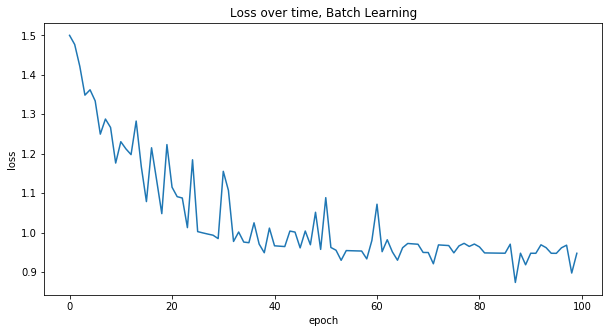

In [5]:
W, loss = train(X, W, batch_size=X.shape[0], shuffle=False)
plot_loss(loss, 'Batch Learning')

100%|██████████| 100/100 [00:00<00:00, 3943.50it/s]


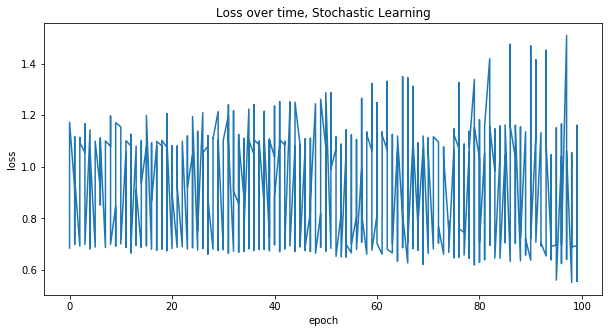

In [6]:
W, loss = train(X, W, batch_size=1, shuffle=True)
plot_loss(loss, 'Stochastic Learning')

100%|██████████| 100/100 [00:00<00:00, 7873.97it/s]


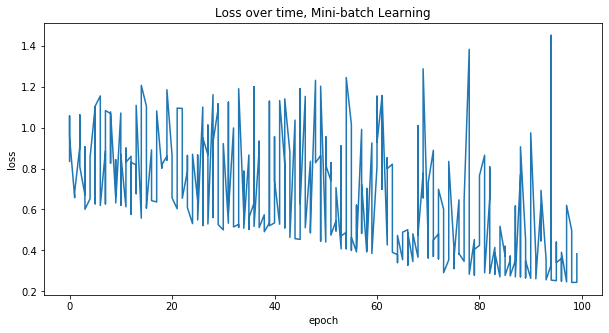

In [7]:
W, loss = train(X, W, batch_size=2, shuffle=True)
plot_loss(loss, 'Mini-batch Learning')

Note that we can query which hidden nodes are activated by the visible nodes. It seems the last 3 visible nodes activate the first hidden node, so the first hidden node must represent Oscar movies. It seems that the first 3 visible nodes activate the second hidden node, so the second hidden node must represent science fiction movies.

In [8]:
query_hidden(np.array([[0, 0, 0, 1, 1, 0]]), n_hidden, W)

array([[1., 0.]])

In [9]:
query_hidden(np.array([[1, 1, 0, 0, 0, 0]]), n_hidden, W)

array([[0., 1.]])

In [10]:
query_visible(np.array([[1, 0]]), n_visible, W)

array([[0., 0., 1., 0., 1., 0.]])

In [11]:
query_visible(np.array([[0, 1]]), n_visible, W)

array([[1., 0., 1., 0., 1., 0.]])

In [12]:
for i in range(10):
    print(daydream(500, n_visible, n_hidden, W))

[1. 1. 0. 1. 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 0.]
[0. 0. 1. 1. 0. 0. 0.]
[1. 1. 0. 1. 1. 0. 0.]
[1. 1. 0. 1. 0. 0. 0.]
[1. 0. 0. 1. 0. 0. 0.]
[1. 1. 0. 1. 0. 0. 0.]
[1. 0. 1. 1. 1. 1. 0.]
[1. 0. 0. 1. 1. 0. 0.]


## Names example

Here, we search for popular English, Chinese, and Indian names, and see if we can use a RBM to model names into types of names. Thus, the visible layer represents letters of a name, and the hidden layer represents the types of name (English, Chinese, and Indian). The way we model the visible layer is interesting because we use one-hot encoding to represent letters (look at the code for more explanations). Each character is represented by a vector of size 27 (26 alphabets plus 1 padding character for spaces). Each name is represented by a 9 x 27 matrix (9 since 9 is the maximum length of a name in this sample, and 27 for the 27 possible characters). The number of nodes in the hidden layers is obviously 3 for the 3 categories of names. Now, we know a priori that there are 3 categories that is why we have 3 hidden nodes. Had we not known, we would have to guess and use other validation measures to determine the number of hidden nodes. Simply defining the number of hidden nodes without knowing anything is not trivial, and is a problem in general with latent variable analysis and architecting deep networks.

In [13]:
import itertools
import math

def get_max_length(names):
    """
    Utility method to get the maximum length of all the names.
    
    :param names: A dictionary of names. Keys are types and values are arrays of names.
    :return: The maximum length of a name.
    """
    max_length = 0
    for k, v in names.items():
        length = max([len(name) for name in v])
        if length > max_length:
            max_length = length
    return max_length

def get_encoding():
    """
    Gets the encoding from letter to indices. Note that space is replaced by the hash symbol/character.
    
    :return: A dictionary where keys are letters and values are indices.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz#'
    d = {}
    for i in range(len(letters)):
        d[letters[i]] = i
    return d

def get_reverse_encoding():
    """
    Gets the encoding from indices to letters. 
    
    :return: A dictionary where keys are indices and values are letters.
    """
    letters = 'abcdefghijklmnopqrstuvwxyz#'
    d = {}
    for i in range(len(letters)):
        d[i] = letters[i]
    return d

def encode_letter(letter, encoding=get_encoding()):
    """
    One-hot encodes a letter to a vector. The vector is all zero except one in the index
    corresponding to the letter.
    
    :param letter: Letter.
    :param encoding: The letter-index encoding.
    :return: One-hot encoded vector representing a letter.
    """
    n = len(encoding)
    ohe = np.zeros(n)
    idx = encoding[letter]
    ohe[idx] = 1
    return ohe

def encode_name(name, max_letters, encoding=get_encoding()):
    """
    One-hot encodes a name into a matrix (or tensor). Note that no matter the name,
    the dimension will always be max_letters x 27. The max_letters is the maximum
    letters (length) that can be in a name. The 27 is due to 26 alphabets plus 1 for
    padding. 
    
    :param name: A name.
    :param max_letters: Maximum letters.
    :param encoding: The letter-index encoding.
    :return: A tensor representing a one-hot encoding of a name.
    """
    name_length = len(name)
    name_ohe = [encode_letter(name[i], encoding) for i in range(name_length)]
    padd_ohe = [encode_letter('#', encoding) for _ in range(name_length, max_letters)]
    
    ohe = []
    ohe.extend(name_ohe)
    ohe.extend(padd_ohe)
    ohe = np.hstack(ohe)
    
    return ohe

def encode_names(names, max_letters, encoding=get_encoding()):
    """
    Encodes all names. The names parameter is a dictionary where keys are
    types (e.g. English, Chinese, Indian) and values are list of names.
    
    :param names: A dictionary of types with names.
    :param max_letters: The maximum letters in a name.
    :param encoding: The letter-index encoding.
    :return: A list of tensors, where each tensor represents one-hot encoding of names.
    """
    data = []
    for k, names in names.items():
        for name in names:
            ohe = encode_name(name, max_letters, encoding)
            data.append(ohe)
    return np.array(data)

def flatten_names(names):
    """
    Flatten out the names. The names parameter is a dictionary where keys are
    types (e.g. English, Chinese, Indian) and values are list of names.
    
    :param names: A dictionary of types with names.
    :return: A list of names.
    """
    data = []
    for k, names in names.items():
        data.extend(names)
    return data

def decode_ohe(v, max_letters, encoding=get_reverse_encoding()):
    """
    Decodes one-hot encoded vector.
    
    :param v: One-hot encoded vector.
    :param max_letters: The maximum letters in a name.
    :param encoding: The index-letter encoding.
    :return: A list of letter sets. e.g. ['ab', 'c', 'defg']
    """
    def encode(row, vector, encoding):
        codes = [encoding[i] for i, c in enumerate(vector[row, :]) if c > 0 and i < 26]
        out = ''.join(codes).strip()
        if len(out) == 0:
            return None
        else:
            return out
    
    vector = v[0,:]
    cols = math.floor(v.shape[1] / max_letters)
    rows = max_letters
    vector = vector.reshape(rows, cols)
    d = []
    for i, row in enumerate(range(rows)):
        v_activations = encode(row, vector, encoding)
        if v_activations is not None and len(v_activations) > 0:
            d.append(v_activations)
    return d

def get_permutation(decoding):
    """
    Gets all permutations of a list of letter sets. For example, if the
    decoding is ['c', 'a', 'trp'] then the result will be ['cat', 'car' 'cap'].
    
    :param decoding: A list of letter sets. e.g. ['c', 'a', 'trp'].
    :return: All permutations between the letter sets.
    """
    return [''.join(t) for t in list(itertools.product(*decoding))]
    
names = {
    'english': [
        'jack', 'thomas', 'joshua', 'william', 'daniel',
        'matthew', 'james', 'joseph', 'harry', 'samuel'
    ],
    'chinese': [
        'wei', 'qiang', 'lei', 'jun', 'yong',
        'jie', 'jin', 'taio', 'de', 'tao'
    ],
    'indian': [
        'mohammed', 'reyansh', 'aarav', 'atharv', 'vivaan',
        'advik', 'ansh', 'ishann', 'dhruv', 'siddharth'
    ]
}

max_letters = get_max_length(names)
encoding = get_encoding()
rencoding = get_reverse_encoding()
raw = encode_names(names, max_letters, encoding)

In [14]:
X = get_data_matrix(raw)

n_visible = raw.shape[1]
n_hidden = 3
W = get_weight_matrix(n_visible, n_hidden)

print('{} X shape'.format(X.shape))
print('{} W shape'.format(W.shape))
print('{} n_visible'.format(n_visible))
print('{} n_hidden'.format(n_hidden))

(30, 244) X shape
(244, 4) W shape
243 n_visible
3 n_hidden


100%|██████████| 100/100 [00:00<00:00, 6159.94it/s]


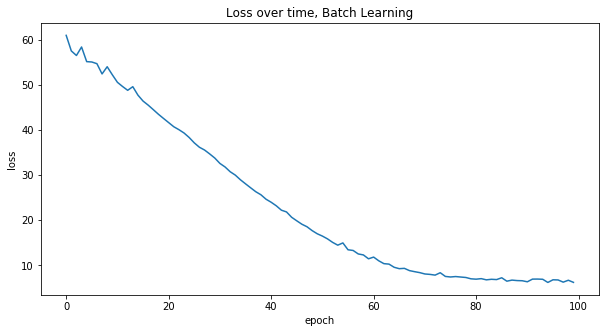

In [15]:
W, loss = train(X, W, batch_size=X.shape[0], shuffle=False)
plot_loss(loss, 'Batch Learning')

100%|██████████| 5000/5000 [00:07<00:00, 698.51it/s]


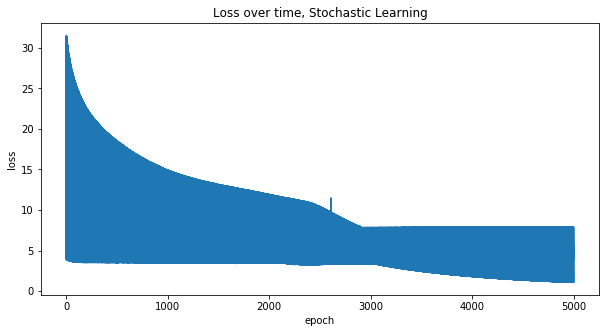

In [16]:
W, loss = train(X, W, max_iters=5000, batch_size=1, shuffle=True)
plot_loss(loss, 'Stochastic Learning')

100%|██████████| 5000/5000 [00:03<00:00, 1308.33it/s]


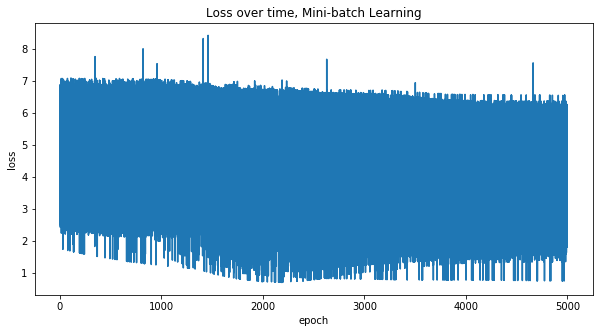

In [17]:
W, loss = train(X, W, max_iters=5000, batch_size=2, shuffle=True)
plot_loss(loss, 'Mini-batch Learning')

It seems that Indian and English names activate the same hidden nodes, while Chinese names activate the first two nodes.

In [18]:
flattened_names = flatten_names(names)

for r in range(len(raw)):
    h = query_hidden(raw[r,:].reshape(1, n_visible), n_hidden, W)
    n = flattened_names[r]
    print('{}: {} {}'.format(r, h, n))

0: [[1. 1. 0.]] jack
1: [[1. 1. 1.]] thomas
2: [[1. 1. 1.]] joshua
3: [[0. 1. 1.]] william
4: [[1. 1. 1.]] daniel
5: [[1. 0. 1.]] matthew
6: [[1. 1. 1.]] james
7: [[1. 1. 1.]] joseph
8: [[1. 1. 1.]] harry
9: [[1. 1. 1.]] samuel
10: [[1. 1. 0.]] wei
11: [[1. 1. 1.]] qiang
12: [[1. 1. 0.]] lei
13: [[1. 1. 0.]] jun
14: [[1. 1. 0.]] yong
15: [[1. 1. 0.]] jie
16: [[1. 1. 0.]] jin
17: [[1. 1. 0.]] taio
18: [[1. 1. 0.]] de
19: [[1. 1. 0.]] tao
20: [[1. 0. 1.]] mohammed
21: [[1. 1. 1.]] reyansh
22: [[1. 1. 1.]] aarav
23: [[1. 1. 1.]] atharv
24: [[1. 1. 1.]] vivaan
25: [[1. 1. 1.]] advik
26: [[1. 1. 1.]] ansh
27: [[1. 1. 1.]] ishann
28: [[1. 1. 1.]] dhruv
29: [[0. 0. 0.]] siddharth


Here we query which visible nodes are activated by the specified hidden nodes. After we find out the activated visible nodes, we take the product of the letters corresponding to the visible nodes and generate names. Note, this step is stochastic and so you will get different results on each run although the same hidden nodes are activated. It seems that turning on 

* the second and third hidden nodes generates English names, 
* the first and second hidden nodes generates Chinese names, and
* the first and third hidden nodes generates Indian names.

In [19]:
', '.join(get_permutation(
    decode_ohe(
        query_visible(np.array([[0, 1, 1]]), n_visible, W), max_letters, rencoding)))

'wileiam, wiluiam'

In [20]:
', '.join(get_permutation(
    decode_ohe(
        query_visible(np.array([[1, 1, 0]]), n_visible, W), max_letters, rencoding)))

'un'

In [21]:
', '.join(get_permutation(
    decode_ohe(
        query_visible(np.array([[1, 0, 1]]), n_visible, W), max_letters, rencoding)))

'lahhvh, lahnvh, lanhvh, lannvh, lhhhvh, lhhnvh, lhnhvh, lhnnvh, mahhvh, mahnvh, manhvh, mannvh, mhhhvh, mhhnvh, mhnhvh, mhnnvh'

Now, we let the RBM daydream about names. =)

In [22]:
for i in range(5):
    dd = daydream(5000, n_visible, n_hidden, W)
    dd = dd.reshape(1, dd.shape[0])
    dd = dd[:,1:]
    dd = get_permutation(decode_ohe(dd, max_letters, rencoding))
    dd = ', '.join(dd)
    print('daydream iteration {}'.format(i + 1))
    print(dd)
    print('')

daydream iteration 1
baddearqh, baddearth, baddeerqh, baddeerth, baddharqh, baddharth, baddherqh, baddherth, baddrarqh, baddrarth, baddrerqh, baddrerth, badeearqh, badeearth, badeeerqh, badeeerth, badeharqh, badeharth, badeherqh, badeherth, baderarqh, baderarth, badererqh, badererth, biddearqh, biddearth, biddeerqh, biddeerth, biddharqh, biddharth, biddherqh, biddherth, biddrarqh, biddrarth, biddrerqh, biddrerth, bideearqh, bideearth, bideeerqh, bideeerth, bideharqh, bideharth, bideherqh, bideherth, biderarqh, biderarth, bidererqh, bidererth, saddearqh, saddearth, saddeerqh, saddeerth, saddharqh, saddharth, saddherqh, saddherth, saddrarqh, saddrarth, saddrerqh, saddrerth, sadeearqh, sadeearth, sadeeerqh, sadeeerth, sadeharqh, sadeharth, sadeherqh, sadeherth, saderarqh, saderarth, sadererqh, sadererth, siddearqh, siddearth, siddeerqh, siddeerth, siddharqh, siddharth, siddherqh, siddherth, siddrarqh, siddrarth, siddrerqh, siddrerth, sideearqh, sideearth, sideeerqh, sideeerth, sideharqh, 